In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from biom import load_table
from skbio.stats.composition import clr, clr_inv, centralize, closure
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
data_dir = '../data/HFD'

microbes = load_table(os.path.join(data_dir, 'microbes.biom')).to_dataframe().T
metabolites = load_table(os.path.join(data_dir, 'metabolites.biom')).to_dataframe().T

# align the samples
ids = set(microbes.index) & set(metabolites.index)
microbes = microbes.loc[ids]
metabolites = metabolites.loc[ids]

# to keep consistent with the mmvec analysis, microbes with less than 10 reads total are dropped
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 3]

In [3]:
microbes.shape, metabolites.shape

((434, 913), (434, 11978))

First, let's load the HFD models that were generated from mmvec.  You may have to modify the checkpoint file to point to files in your own filesystem.

In [4]:
summary_dir = ('../results/hfd_output/latent_dim_3_input_prior_0.10_output_prior_0.10_beta1_0.85_beta2_0.90')

fname = os.path.join(summary_dir, 'model.ckpt-3729909.meta')
with tf.Session() as sess:

    new_saver = tf.train.import_meta_graph(fname)

    print(summary_dir)
    print(fname)
    new_saver.restore(
        sess, tf.train.latest_checkpoint(summary_dir)
    )
                      
    graph = tf.get_default_graph()
    qU = graph.get_tensor_by_name("qU:0").eval()
    qV = graph.get_tensor_by_name("qV:0").eval()
    qUbias = graph.get_tensor_by_name("qUbias:0").eval()
    qVbias = graph.get_tensor_by_name("qVbias:0").eval()

../results/hfd_output/latent_dim_3_input_prior_0.10_output_prior_0.10_beta1_0.85_beta2_0.90
../results/hfd_output/latent_dim_3_input_prior_0.10_output_prior_0.10_beta1_0.85_beta2_0.90/model.ckpt-3729909.meta
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/jmorton/Documents/dev/multiomic-cooccurences/results/hfd_output/latent_dim_3_input_prior_0.10_output_prior_0.10_beta1_0.85_beta2_0.90/model.ckpt-3729909


In [5]:
np.savetxt('../results/hfd_output/U.txt', qU)
np.savetxt('../results/hfd_output/Ubias.txt', qUbias)
np.savetxt('../results/hfd_output/V.txt', qV)
np.savetxt('../results/hfd_output/Vbias.txt', qVbias)

In [6]:
from scipy.stats import rankdata


U_ = np.hstack(
    (np.ones((qU.shape[0], 1)),
     qUbias.reshape(-1, 1), qU)
)
V_ = np.vstack(
    (qVbias.reshape(1, -1),
     np.ones((1, qV.shape[1])), qV)
)

coefs = pd.DataFrame(
    clr(centralize(clr_inv(np.hstack(
        (np.zeros((qU.shape[0], 1)), U_ @ V_))))),
    index=microbes.columns,
    columns=metabolites.columns)

ranks = coefs.apply(rankdata, axis=1)
ranks = pd.DataFrame(np.vstack(list(ranks.values)), columns=coefs.columns, index=coefs.index)

Center the metabolite embedding around zero via conversion to clr coordinates.  Then center the microbe embedding around zero before saving both of them to files.

In [7]:
from scipy.sparse.linalg import svds
metabolite_embed = clr(clr_inv(np.hstack((np.zeros((qV.shape[0], 1)), qV)))).T
microbe_embed = qU

# orthogonalize them
metabolite_embed = np.linalg.qr(metabolite_embed)[0]
microbe_embed = np.linalg.qr(microbe_embed)[0]

pc_ids = ['PC1', 'PC2', 'PC3']
metabolites_res = OrdinationResults('PCA', 'Aitchison PCA for metabolites',
    eigvals = pd.Series([1, 1, 1], index=pc_ids),
    proportion_explained = pd.Series([.33, .33, .33], index=pc_ids),
    samples=pd.DataFrame(metabolite_embed,
                         columns=pc_ids, index=metabolites.columns))
metabolites_res.write('../results/hfd_output/metabolites-pca.results')

microbes_res = OrdinationResults('PCA', 'Aitchison PCA for microbes',
    eigvals = pd.Series([1, 1, 1], index=pc_ids),
    proportion_explained = pd.Series([.33, .33, .33], index=pc_ids),
    samples=pd.DataFrame(microbe_embed, 
                         columns=pc_ids, index=microbes.columns))
microbes_res.write('../results/hfd_output/microbes-pca.results')

'../results/hfd_output/microbes-pca.results'

We have the following manually verified annotations

Negative control: 466.31589984252_4.92385391891891. 

Clostridia: 

Bile acids:
- 482.329390854131_5.87841747685184   
- 522.377310057874_6.19744051987767
- 572.357768136544_5.48826949404761
- 556.363160911343_6.21811928374655 
- 466.31589984252_4.92385391891891  (Glycocholic acid)
- 516.299420138369_4.74766126248864 
- 540.370156770238_7.28549563189142 (Phe conjugated chenodeoxycholic acid)
- 556.363160911343_6.21811928374655 (Phe conjugated cholic acid)


(Exclude below for now)

ABX-related molecules:
- 355.2631_338.9456
- 712.7983_ 99.9473
- 956.9507_152.2731
- 175.1139_112.2690
- 283.2634_560.0218

NASH-related molecules
- 524.3713_508.6635
- 166.0863_ 71.3910
- 120.0806_ 71.4547
- 391.2844_311.5497

Threshold for retention time

+/- 10 s

Threshold for m/z

+/- 0.01

In [8]:
bile_acids = [
    [482.329390854131, 5.87841747685184],
    [522.377310057874, 6.19744051987767],
    [572.357768136544, 5.48826949404761],
    [556.363160911343, 6.21811928374655],
    [466.31589984252, 4.92385391891891],
    [516.299420138369, 4.74766126248864],
    [540.370156770238, 7.28549563189142],
    [556.363160911343, 6.21811928374655]
]

abx = [    
    [355.2631, 338.9456],
    [712.7983, 99.9473],
    [956.9507, 152.2731],
    [175.1139, 112.2690],
    [283.2634, 560.0218]
]

nash = [
    [524.3713, 508.6635],
    [166.0863, 71.3910],
    [120.0806, 71.4547],
    [391.2844, 311.5497]
]

But we'll need to first format the metabolomics annotations and create a look up data structure.

In [9]:
from sklearn.neighbors import NearestNeighbors, KDTree


def split_rt_mz(x):
    if len(x.split('.')) > 3:
        x = '.'.join(x.split('.')[:2])
    
    t = x.split('_')
    return float(t[0]), float(t[1])

ms_md = pd.DataFrame(
    list(map(split_rt_mz, coefs.columns)), 
    index=coefs.columns, columns=['m/z', 'rt']) 

lookup = NearestNeighbors()
lookup.fit(ms_md.values) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Now, let's serialize all of the manual annotations and link them to the MS retention times and m/z.

In [10]:
results = []
for x in bile_acids:
    d, i = lookup.kneighbors([x], 1)
    results.append((ms_md.index[i][0][0], 'bile_acid'))

for x in abx:
    d, i = lookup.kneighbors([x], 1)
    results.append((ms_md.index[i][0][0], 'abx'))

for x in nash:
    d, i = lookup.kneighbors([x], 1)
    results.append((ms_md.index[i][0][0], 'nash'))    
results = pd.DataFrame(results, columns=['ms_id', 'compound_type'])    

We'll want to do the same for taxonomy

In [11]:
!ls ../data/HFD

cleaned_qiime_metadata.txt      microbe_feature_metadata.txt
metabolite_feature_metadata.txt microbes.biom
metabolites.biom                taxonomy.tsv


In [12]:
taxa = pd.read_table('../data/HFD/taxonomy.tsv')
t = pd.DataFrame([ i for i in taxa.Taxon.apply(lambda x: x.split(';'))], 
             columns=['kingdom', 'phylum', 'class', 'order', 
                      'family', 'genus', 'species']
            )
taxa = pd.concat((taxa, t), axis=1)
taxa = taxa.set_index('Feature ID')

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


Now we'll want to sync against the differential abundance results

In [13]:
microbe_beta = pd.read_csv(
    '../results/hfd_output/songbird_microbes_prior1_lr1e-3_diet_rerun3/differentials.csv', 
    index_col=0)
microbe_metadata = pd.merge(microbe_beta, taxa, left_index=True, right_index=True)
microbe_metadata.index.name = 'featureid'
microbe_metadata['otu_id'] = ['OTU_%d' % i for i in range(len(microbe_metadata.index))]

In [14]:
!ls ../data/HFD

cleaned_qiime_metadata.txt      microbe_feature_metadata.txt
metabolite_feature_metadata.txt microbes.biom
metabolites.biom                taxonomy.tsv


In [15]:
# create low dimensional projection of svd
dim = 3
u, s, v = np.linalg.svd(clr(centralize(coefs.apply(clr_inv).T)))
u_ = u[:, :dim]
s_ = s[:dim]
v_ = v[:dim, :]

scale = 1.4
n = u.shape[0] 
u = (u_ * np.sqrt(n-1)) / scale
v = (scale * v_ * s_.reshape(-1, 1)) / (np.sqrt(n-1))

pcids = ['PC%d' % i for i in range(dim)]
samples = pd.DataFrame(u, index=coefs.columns, columns=pcids)
features = pd.DataFrame(v.T, index=coefs.index, columns=pcids)
eigvals = pd.Series(s[:dim], index=pcids)

features['importance'] = features.apply(lambda x: euclidean(np.zeros_like(x), x), axis=1)
features.sort_values('importance', inplace=True, ascending=False)
features.drop(['importance'], inplace=True, axis=1)

# match against metadata
microbe_metadata, features = microbe_metadata.align(features, axis=0, join='inner')

microbe_metadata.index.name = 'featureid'
#microbe_metadata.to_csv('../data/HFD/microbe_feature_metadata.txt', sep='\t')

res = OrdinationResults('RegressionBiplot', 'Multinomial Regression Biplot',
                        eigvals = eigvals,
                        proportion_explained = eigvals / eigvals.sum(),
                        samples=samples, features=features)

# save results
res.write('../results/hfd_output/omics-biplot.results')

'../results/hfd_output/omics-biplot.results'

In [16]:
cranks = ranks - ranks.mean(axis=1).values.reshape(-1, 1)
edges = pd.melt(cranks.reset_index(), id_vars='index')
edges = edges.sort_values('value', ascending=False).iloc[:300]
edges = edges.rename(columns={'index': 'microbe', 'variable': 'metabolite', 'value': 'cond_logit'})
edges.set_index('microbe').to_csv('../results/hfd_output/edges.txt', sep='\t')

Now, let's try to extract potentially interesting microbes, especially those that are associated with Phe conjugated cholic acid and Phe conjugated chenodeoxycholic acid

Phe conjugated cholic acid

In [17]:
ranks['556.363066229926_6.25189184149183'].argmax()

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


'TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCTTGGCAAGTCAGTAGTGAAATCCATGGGCTTAACCCATGAACTGCTATTGAAACTGTCGAGCTTGAGTGAAGTAGAGGTAGGCGGAATTCCCGG'

The rank of the most associated microbe is given below.

In [18]:
ranks.shape[1] - ranks['556.363066229926_6.25189184149183'].max()

22.0

In [19]:
microbe_metadata.loc[ranks['556.363066229926_6.25189184149183'].argmax()]

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


Intercept                                                 1.115
diet[T.NC]                                              0.28551
Taxon         k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                             0.985994
kingdom                                             k__Bacteria
phylum                                            p__Firmicutes
class                                             c__Clostridia
order                                          o__Clostridiales
family                                       f__Ruminococcaceae
genus                                           g__Ruminococcus
species                                                     s__
otu_id                                                  OTU_155
Name: TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCTTGGCAAGTCAGTAGTGAAATCCATGGGCTTAACCCATGAACTGCTATTGAAACTGTCGAGCTTGAGTGAAGTAGAGGTAGGCGGAATTCCCGG, dtype: object

In [20]:
coefs.loc[ranks['556.363066229926_6.25189184149183'].argmax(), '556.363066229926_6.25189184149183']

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


0.26226389530276073

This microbe is Acutalibacter muris which is a Clostrium.  This is commonly found in mouse poop

https://www.nature.com/articles/nmicrobiol2016131

Next is Phe conjugated chenodeoxycholic acid

In [21]:
ranks['540.370161766654_7.29027895783612'].argmax()

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


'TACGGAGGATCCGAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGTAGGTTGTTTTATAAGTTAGCGGTGAAATACCGATGCTCAACATCGGGGCTGCCGCTAATACTGTAGGACTAGAGATCGGATGCAGCAGGCGGAATGTGTAG'

In [22]:
ranks.shape[1] - ranks['540.370161766654_7.29027895783612'].max()

358.0

In [23]:
ranks['540.370161766654_7.29027895783612'].argmax()

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


'TACGGAGGATCCGAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGTAGGTTGTTTTATAAGTTAGCGGTGAAATACCGATGCTCAACATCGGGGCTGCCGCTAATACTGTAGGACTAGAGATCGGATGCAGCAGGCGGAATGTGTAG'

Top hit: Alistipes sp - found in colon cancer
    
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2828066/

In [24]:
coefs.loc[ranks['540.370161766654_7.29027895783612'].argmax(), '540.370161766654_7.29027895783612']

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


0.41388439394076926

In [25]:
alistipes = ranks['540.370161766654_7.29027895783612'].argmax()
acutalibacter = ranks['556.363066229926_6.25189184149183'].argmax()

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


Now let's start to look at some of these microbes

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


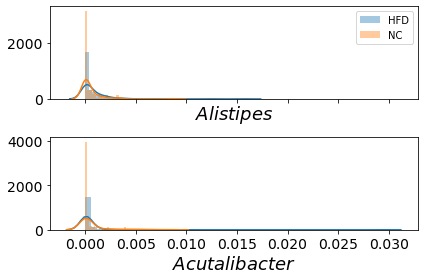

In [26]:
rel_microbes = microbes.apply(lambda x: x / x.sum(), axis=1)
sample_metadata = pd.read_table('../data/HFD/cleaned_qiime_metadata.txt', index_col=0)
data = pd.merge(sample_metadata, rel_microbes, left_index=True, right_index=True)

# plot these microbes relative abundances
import matplotlib
import seaborn as sns
matplotlib.rc('text', usetex = False)

fig, ax = plt.subplots(2, 1, sharex=True)

idx = data.diet == 'NC'
sns.distplot(data.loc[~idx, alistipes], label='HFD', ax=ax[0])
sns.distplot(data.loc[idx, alistipes], label='NC', ax=ax[0])
ax[0].set_xlabel('$Alistipes$', fontsize=18)
ax[0].tick_params(labelsize=14)
ax[0].legend()

sns.distplot(data.loc[~idx, acutalibacter], ax=ax[1])
sns.distplot(data.loc[idx, acutalibacter], ax=ax[1])
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel('$Acutalibacter$', fontsize=18)
plt.tight_layout()

In [27]:
micro_diff = pd.read_csv('../results/hfd_output/songbird_microbes_prior1_lr1e-3_diet_rerun3/differentials.csv',
                         index_col=0)
seqs = {
    'Bifidobacteriaceae': 'TACGTAGGGTGCAAGCGTTATCCGGATTTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGG',
    'Enterobacteriaceae1': 'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGG',
    'Enterobacteriaceae2': 'TACGTAGGGTGCAAGCGTTATCCGGATTTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGG',
    'Ruminococcus_gnavis': 'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGATGCAAGCCAGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTTGGAACTGTGTGGCTGGAGTGTCGGAGAGGCAAGTGGAATTCCTAG',
    'Lactobacillus reuteri1': 'TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATG',
    'Lactobacillus reuteri2': 'TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGTGCATCGGAAACCGGGCAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATG'
}

Text(0.5, 0, 'Taxa')

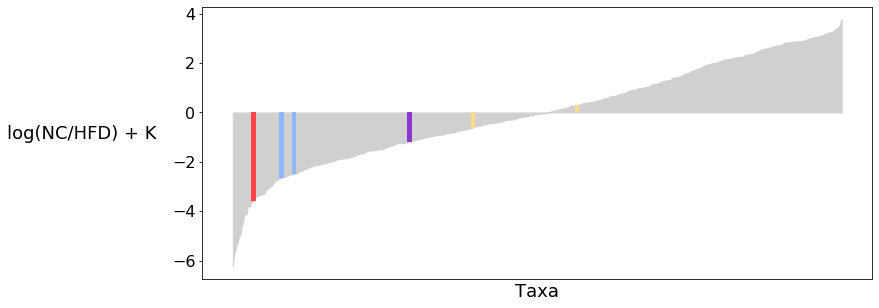

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
diet_ranks = micro_diff['diet[T.NC]'].sort_values()
w = 5

y = diet_ranks.values
x = np.arange(len(y))
ax.fill_between(x, y, 0, interpolate=True, color='#d0d0d0')
i = diet_ranks.index.get_loc(alistipes)
ax.bar(x[i], y[i], w, color='#fedb87')

i = diet_ranks.index.get_loc(acutalibacter)
ax.bar(x[i], y[i], w, color='#fedb87') 
ax.set_xticks([]) 

i = np.array([diet_ranks.index.get_loc(seqs['Enterobacteriaceae1']),
              diet_ranks.index.get_loc(seqs['Enterobacteriaceae2'])])
ax.bar(x[i], y[i], w, color='#ff4545') 
ax.set_xticks([]) 

i = np.array([diet_ranks.index.get_loc(seqs['Lactobacillus reuteri1']),
              diet_ranks.index.get_loc(seqs['Lactobacillus reuteri2'])])
ax.bar(x[i], y[i], w, color='#90b7fe') 
ax.set_xticks([]) 

i = np.array([diet_ranks.index.get_loc(seqs['Bifidobacteriaceae'])])
ax.bar(x[i], y[i], w, color='#8d35cf') 
ax.set_xticks([]) 

ax.tick_params(labelsize=16)
ax.set_ylabel('log(NC/HFD) + K', rotation=0, labelpad=90, fontsize=18)
ax.set_xlabel('Taxa', fontsize=18)

Let's look at the firmicutes and bacteriodetes ratio, just for fun.

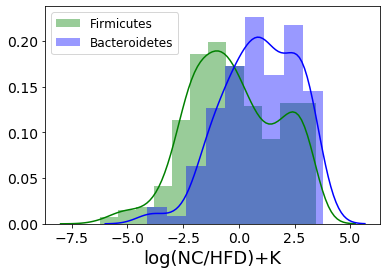

In [29]:
fig, ax = plt.subplots()
subtaxa = taxa.loc[set(microbes.columns) & set(diet_ranks.index)]
firmicutes = subtaxa.loc[subtaxa.phylum == ' p__Firmicutes'].index
bacteroidetes = subtaxa.loc[subtaxa.phylum == ' p__Bacteroidetes'].index
sns.distplot(diet_ranks.loc[firmicutes], color='g', label='Firmicutes', ax=ax)
sns.distplot(diet_ranks.loc[bacteroidetes], color='b', label='Bacteroidetes', ax=ax)
ax.set_xlabel('log(NC/HFD)+K', fontsize=18)
ax.tick_params(labelsize=14)
ax.legend(fontsize=12) 

And we'll perform a comparison between mmvec and pearson

In [30]:
from scipy.stats import pearsonr

rel_microbes = microbes.apply(lambda x: x/x.sum(), axis=1)
rel_metabolites = metabolites.apply(lambda x: x/x.sum(), axis=1)

pear_coefs = pd.Series(index=metabolites.columns)
pear_pvals = pd.Series(index=metabolites.columns)
for j in metabolites.columns:
    res = pearsonr(rel_microbes[acutalibacter], rel_metabolites[j])
    pear_coefs.loc[j] = res[0]
    pear_pvals.loc[j] = res[1]

In [31]:
pear_coefs = pear_coefs.sort_index()
pear_pvals = pear_pvals.sort_index()
acut_ranks = coefs.loc[acutalibacter].sort_index()

Text(0, 0.5, 'Pearson correlations')

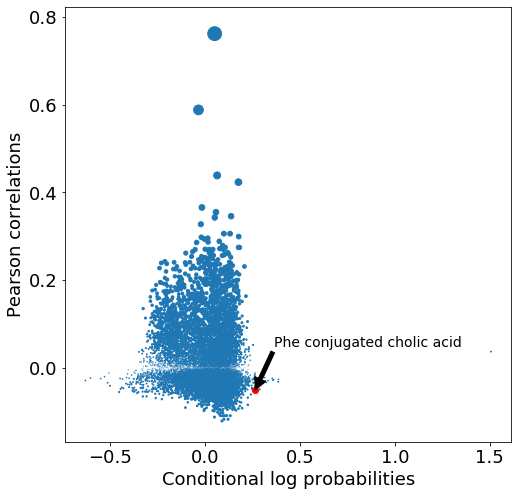

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(acut_ranks, pear_coefs, s=-np.log(pear_pvals))
ax.scatter(
    acut_ranks.loc['556.363066229926_6.25189184149183'],
    pear_coefs.loc['556.363066229926_6.25189184149183'],
    c='r'
)


dx = 0.1
dy = 0.1

x = acut_ranks.loc['556.363066229926_6.25189184149183']
y = pear_coefs.loc['556.363066229926_6.25189184149183']
ax.annotate('Phe conjugated cholic acid', xy=(x, y), xytext=(x+dx, y+dy), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.01))
    
    
ax.tick_params(labelsize=18)
ax.set_xlabel('Conditional log probabilities', fontsize=18)
ax.set_ylabel('Pearson correlations', fontsize=18)